<a href="https://colab.research.google.com/github/RubenRomeroTorrado/Final-project-potato/blob/main/Untitled0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fastai
!pip install gradio
!pip install pillow
!pip install scikit-image
!pip install split-folders

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
import splitfolders
import zipfile
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torch import nn
from torch.optim import Adam
from torchvision import models

from sklearn.metrics import classification_report, confusion_matrix

from torchvision.datasets import ImageFolder
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import torch
import torchvision
from pathlib import Path

import torch
from torch.utils.data import Dataset
from PIL import Image



In [ ]:

caminho_zip = '/content/archive.zip'
pasta_destino = '/content/dataset'

if not os.path.exists(caminho_zip):
    raise FileNotFoundError(f'O arquivo ZIP não foi encontrado: {caminho_zip}')
if not os.path.exists(pasta_destino):
    os.makedirs(pasta_destino)
try:
    with zipfile.ZipFile(caminho_zip, 'r') as zip_ref:
         zip_ref.extractall(pasta_destino)
    print(f'Arquivos extraídos para {pasta_destino}')
except Exception as e:
    print(f'Erro ao extrair arquivos: {e}')
data_set = os.path.join(pasta_destino, 'Potato Pest Dataset')


Arquivos extraídos para /content/dataset


In [ ]:
classes = os.listdir(pasta_destino)
class_images = {}
for class_name in classes:
    class_images[class_name] = random.sample(os.listdir(os.path.join(pasta_destino, class_name)), 8)
class_images

{'Potato Pest Dataset': ['SL03 Aphis gossypii Glover',
  'SL02 Amrasca devastans (Distant)',
  'SL15 Myzus persicae (Sulzer)',
  'SL06 Brachytrypes portentosus Lichtenstein',
  'SL17 Phthorimaea operculella (Zeller)',
  'SL05 Bemisia tabaci (Gennadius)',
  'SL10 Epilachna vigintioctopunctata (Fabricius)',
  'SL01 Agrotis ipsilon (Hufnagel)']}

In [ ]:
split_output_path = '/content/splitted_data'
splitfolders.ratio(data_set,
                   output=split_output_path,
                   seed=42,
                   ratio=(.7, .2, .1),
                   group_prefix=None,
                   move=False)
print('Dataset dividido em conjuntos de Treinamento, Validação e Teste.')


Copying files: 495 files [00:00, 3797.78 files/s]

Dataset dividido em conjuntos de Treinamento, Validação e Teste.


Dataset Labels:
 {'SL01 Agrotis ipsilon (Hufnagel)': 0, 'SL02 Amrasca devastans (Distant)': 1, 'SL03 Aphis gossypii Glover': 2, 'SL05 Bemisia tabaci (Gennadius)': 3, 'SL06 Brachytrypes portentosus Lichtenstein': 4, 'SL10 Epilachna vigintioctopunctata (Fabricius)': 5, 'SL15 Myzus persicae (Sulzer)': 6, 'SL17 Phthorimaea operculella (Zeller)': 7} 

Images per Class in TRAIN:
0    97
6    52
5    49
1    43
7    29
2    25
3    24
4    24
Name: count, dtype: int64 

Images per Class in VALIDATION:
0    27
6    15
5    14
1    12
7     8
2     7
3     7
4     7
Name: count, dtype: int64 

Images per Class in TEST:
0    15
6     8
1     7
5     7
2     5
7     5
3     4
4     4
Name: count, dtype: int64 

Train classes: ['SL01 Agrotis ipsilon (Hufnagel)', 'SL02 Amrasca devastans (Distant)', 'SL03 Aphis gossypii Glover', 'SL05 Bemisia tabaci (Gennadius)', 'SL06 Brachytrypes portentosus Lichtenstein', 'SL10 Epilachna vigintioctopunctata (Fabricius)', 'SL15 Myzus persicae (Sulzer)', 'SL17 Phth

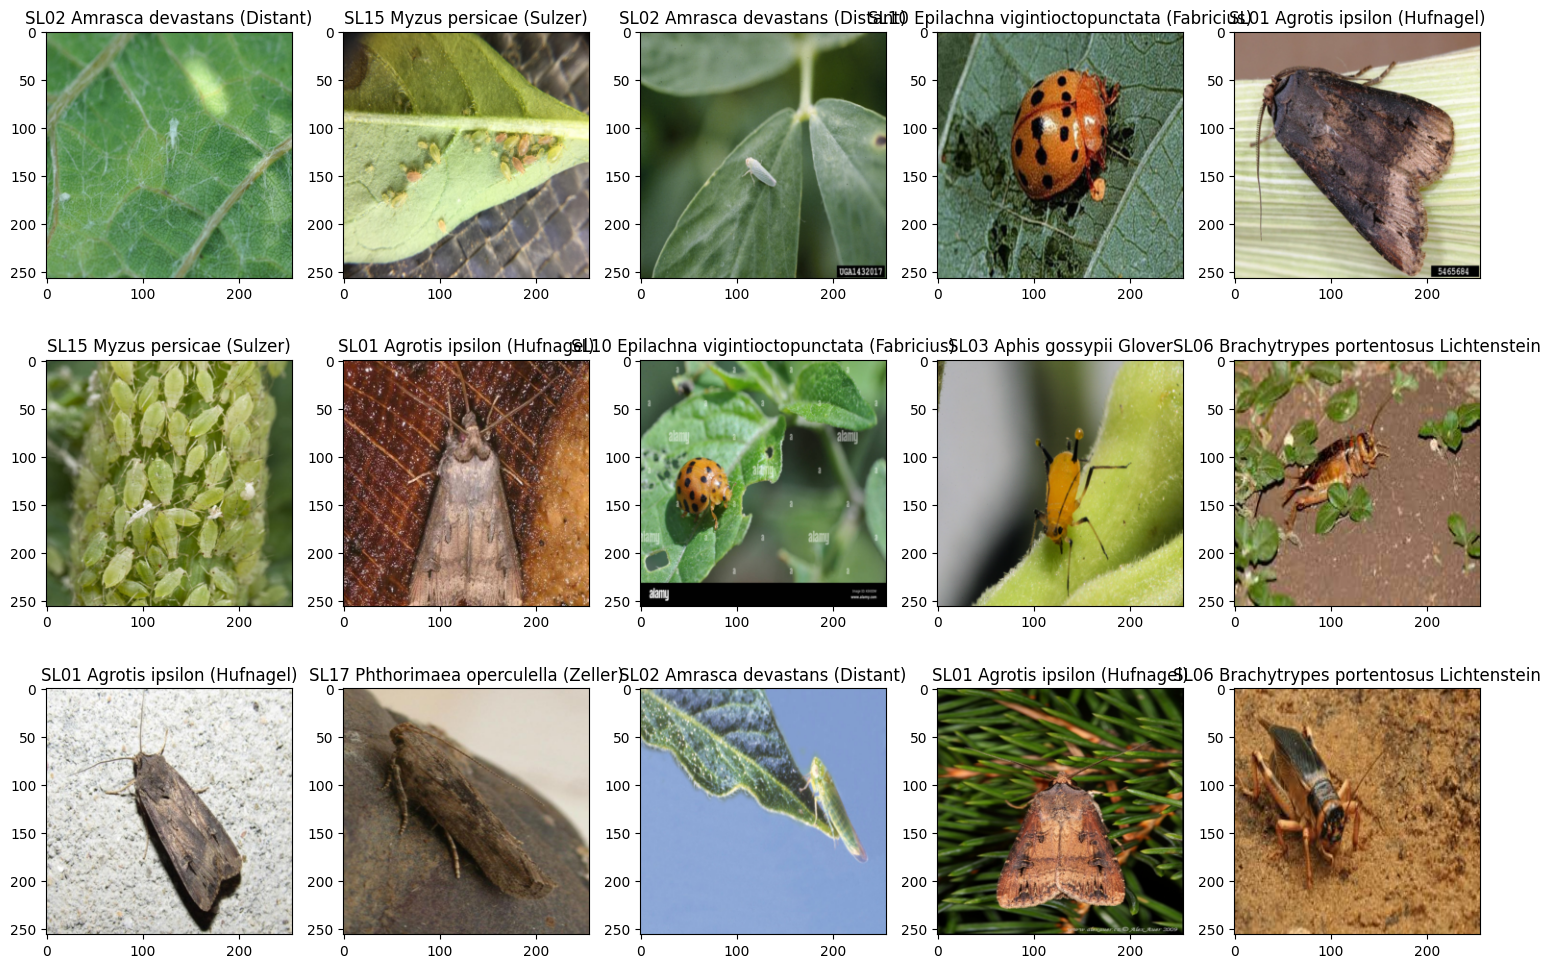

In [ ]:
class CustomImageFolder(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.images = []
        self.targets = []
        self.class_to_idx = {}
        self.classes = sorted(os.listdir(root))

        for idx, cls in enumerate(self.classes):
            self.class_to_idx[cls] = idx
            class_path = os.path.join(root, cls)
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                self.images.append(image_path)
                self.targets.append(idx)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        target = self.targets[idx]

        return image, target

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.GaussianBlur(kernel_size=(3, 7), sigma=(0.1, 2)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


data_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.ToTensor(),
])

train = CustomImageFolder(root="/content/splitted_data/train", transform=train_transform)
val = CustomImageFolder(root="/content/splitted_data/val", transform=val_transform)
test = CustomImageFolder(root="/content/splitted_data/test", transform=test_transform)


data = CustomImageFolder(root="/content/dataset/Potato Pest Dataset", transform=data_transform)

print("Dataset Labels:\n", train.class_to_idx, "\n")

for name, dataset in zip(["TRAIN", "VALIDATION", "TEST"], [train, val, test]):
    images_per_class = pd.Series(dataset.targets).value_counts()
    print(f"Images per Class in {name}:")
    print(images_per_class, "\n")

print("Train classes:", train.classes)
print("Validation classes:", val.classes)
print("Test classes:", test.classes)

print("Number of training samples:", len(train))
print("Number of validation samples:", len(val))
print("Number of test samples:", len(test))

labels_for_viz = {v: k for k, v in data.class_to_idx.items()}

fig, ax = plt.subplots(3, 5, figsize=(15, 10))
ax = ax.flatten()
for i in range(15):
    sample = random.randint(0, len(data) - 1)
    ax[i].imshow(data[sample][0].permute(1, 2, 0))
    ax[i].title.set_text(labels_for_viz[data[sample][1]])

plt.tight_layout()
plt.show()


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

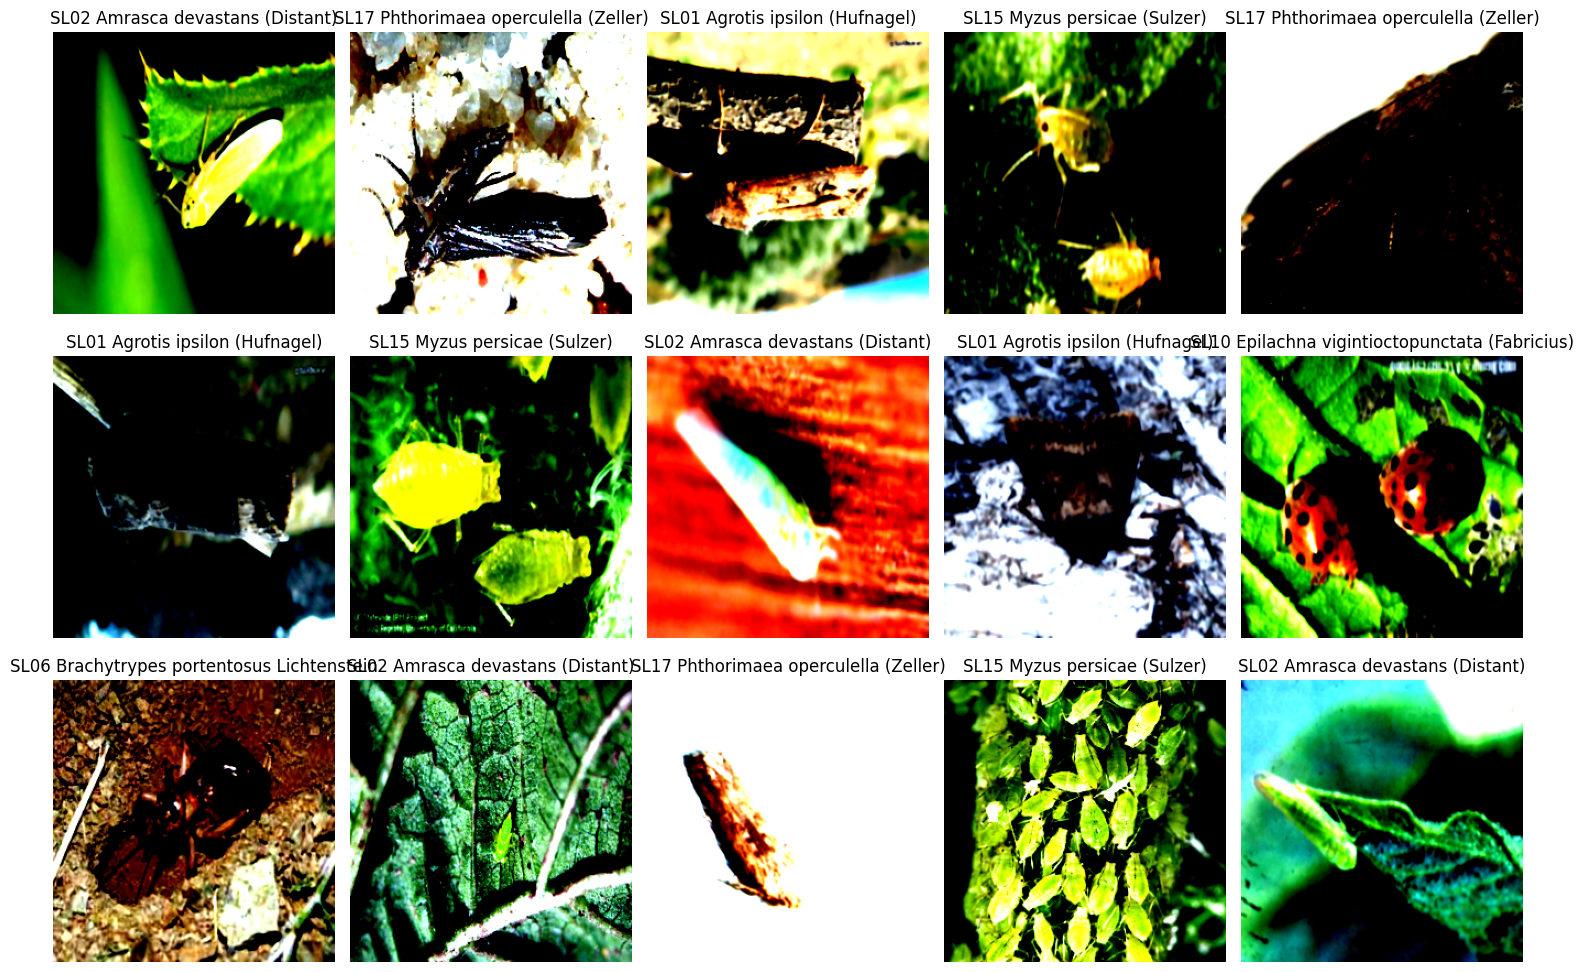

In [ ]:



labels_for_viz = {v: k for k, v in train.class_to_idx.items()}

fig, ax = plt.subplots(3, 5, figsize=(15, 10))
ax = ax.flatten()

for i in range(15):
    sample = random.randint(0, len(train) - 1)
    img, label = train[sample]
    ax[i].imshow(img.permute(1, 2, 0))
    ax[i].title.set_text(labels_for_viz[label])
    ax[i].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
import splitfolders
import warnings


train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_dataset = datasets.ImageFolder(root='/content/splitted_data/train', transform=train_transform)
val_dataset = datasets.ImageFolder(root='/content/splitted_data/val', transform=val_transform)

test_dataset = datasets.ImageFolder(root='/content/splitted_data/test', transform=val_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

class PestClassifier(nn.Module):
    def __init__(self, num_classes):
        super(PestClassifier, self).__init__()
        self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)


num_classes = len(train_dataset.classes)


model = PestClassifier(num_classes=num_classes)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

def train_and_validate_model(epochs):
    train_accuracy_history = []
    val_accuracy_history = []
    train_loss_history = []
    val_loss_history = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_loss_history.append(train_loss)
        train_accuracy_history.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total
        val_loss_history.append(val_loss)
        val_accuracy_history.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    return train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history

EPOCHS = 10
train_accuracy_history, val_accuracy_history, train_loss_history, val_loss_history = train_and_validate_model(EPOCHS)
print("Training finished...\n")

def test_model():
    model.eval()
    all_preds = []
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())

    test_accuracy = 100 * correct / total
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    return all_preds

all_preds = test_model()


Epoch 1/10, Train Loss: 1.4442, Train Accuracy: 55.39%, Val Loss: 0.9238, Val Accuracy: 80.41%
Epoch 2/10, Train Loss: 0.5448, Train Accuracy: 87.76%, Val Loss: 0.3173, Val Accuracy: 87.63%
Epoch 3/10, Train Loss: 0.2153, Train Accuracy: 96.79%, Val Loss: 0.1404, Val Accuracy: 95.88%
Epoch 4/10, Train Loss: 0.0915, Train Accuracy: 98.83%, Val Loss: 0.1183, Val Accuracy: 93.81%
Epoch 5/10, Train Loss: 0.0712, Train Accuracy: 98.83%, Val Loss: 0.1491, Val Accuracy: 93.81%
Epoch 6/10, Train Loss: 0.0487, Train Accuracy: 99.13%, Val Loss: 0.1730, Val Accuracy: 93.81%
Epoch 7/10, Train Loss: 0.0242, Train Accuracy: 99.71%, Val Loss: 0.1436, Val Accuracy: 93.81%
Epoch 8/10, Train Loss: 0.0522, Train Accuracy: 99.42%, Val Loss: 0.1562, Val Accuracy: 93.81%
Epoch 9/10, Train Loss: 0.0496, Train Accuracy: 98.83%, Val Loss: 0.2008, Val Accuracy: 93.81%
Epoch 10/10, Train Loss: 0.0344, Train Accuracy: 99.13%, Val Loss: 0.1720, Val Accuracy: 95.88%
Training finished...

Test Accuracy: 87.27%


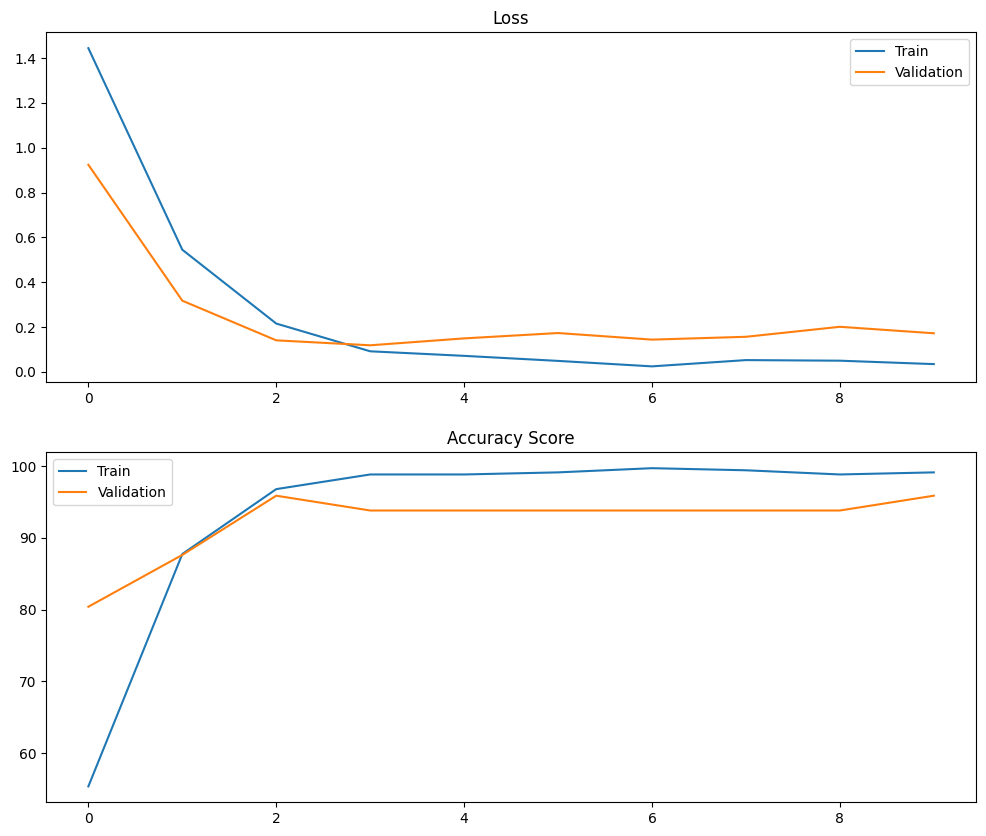

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
ax = ax.flatten()

ax[0].plot(train_loss_history, label="Train")
ax[0].plot(val_loss_history, label="Validation")
ax[0].title.set_text("Loss")
ax[0].legend()

ax[1].plot(train_accuracy_history, label="Train")
ax[1].plot(val_accuracy_history, label="Validation")
ax[1].title.set_text("Accuracy Score")
ax[1].legend()

plt.show()

In [ ]:
print(classification_report(test.targets, all_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.88      1.00      0.93         7
           2       0.33      0.40      0.36         5
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         7
           6       0.67      0.50      0.57         8
           7       1.00      1.00      1.00         5

    accuracy                           0.87        55
   macro avg       0.86      0.86      0.86        55
weighted avg       0.88      0.87      0.87        55



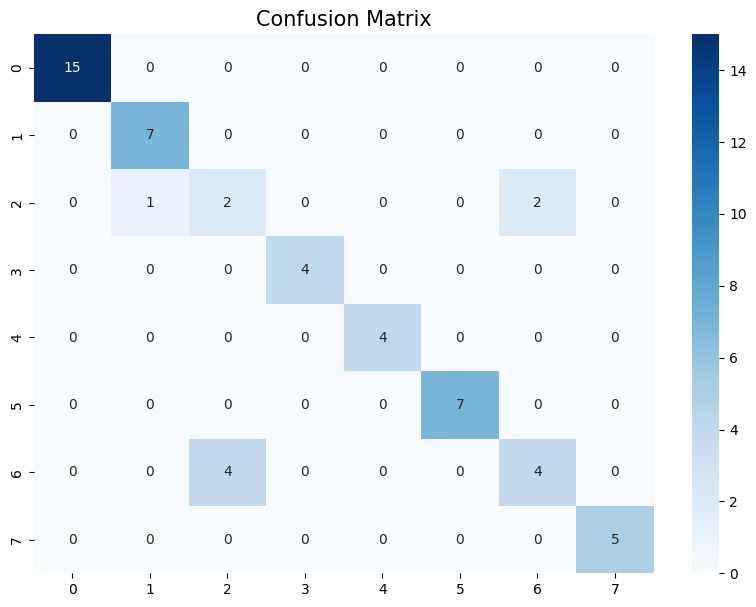

In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(test.targets, all_preds), cmap="Blues", annot=True, fmt="d")
plt.title("Confusion Matrix", size=15)
plt.show()

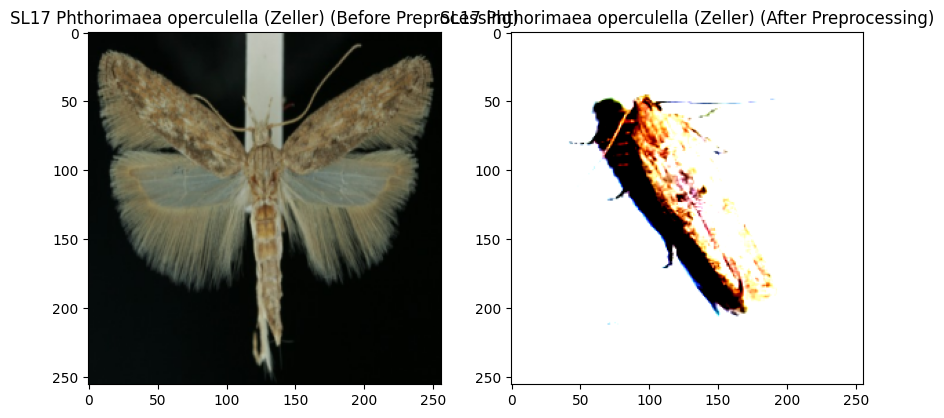

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax = ax.flatten()

ax[0].imshow(data[-1][0].permute(1, 2, 0))
ax[0].title.set_text(f"{labels_for_viz[data[-1][1]]} (Before Preprocessing)")

ax[1].imshow(test[-1][0].permute(1, 2, 0))
ax[1].title.set_text(f"{labels_for_viz[test[-1][1]]} (After Preprocessing)")
plt.show()

In [ ]:
torch.save(model.state_dict(), "model4.pth")